# 2. Fine tuning PsPNet segmentation_models

In [1]:
import os
import re

import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import color

from IPython.display import Image, display
import PIL
from PIL import ImageOps
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

import segmentation_models as sm
sm.set_framework('tf.keras')

import albumentations as A

import tensorflow as tf
import keras
print("tensorflow:", tf.__version__)

Segmentation Models: using `keras` framework.
tensorflow: 2.8.0


In [2]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

#set_memory_growth
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

#seg GPI
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

['/device:CPU:0', '/device:GPU:0']


## Setting up variables and images/segmentation paths

In [3]:
HEIGHT = 384
WIDTH = 384
IMG_SIZE = (WIDTH, HEIGHT)
CLASSES = ['void', 'flat', 'construction', 'object', 'nature', 
               'sky', 'human', 'vehicle']

In [4]:
TRAIN_INPUT_DIR="local_dataset/leftImg8bit/train"
TRAIN_MASK_DIR="local_dataset/gtFine/train"

VAL_INPUT_DIR = "local_dataset/leftImg8bit/val"
VAL_MASK_DIR = "local_dataset/gtFine/val"

TEST_INPUT_DIR = "local_dataset/leftImg8bit/test"
TEST_MASK_DIR = "local_dataset/gtFine/test"

In [5]:
def img_paths(input_dir, mask_dir):
    img_paths=[]
    mask_paths=[]
    for path, subdirs, files in os.walk(input_dir):
        for fname in files:
            if fname.endswith(".png"):
                #image paths
                img_path = os.path.join(path, fname)
                img_paths.append(img_path)
                
                #mask paths
                mask_path = re.sub(input_dir, mask_dir, img_path) #change path
                mask_path = re.sub("leftImg8bit.png", "gtFine_labelIds.png", mask_path) #change mask name
                #path validity check
                if os.path.isfile(mask_path):
                    mask_paths.append(mask_path)
                else:
                    print ("File not exist:", mask_path)
                
    return img_paths, mask_paths

In [6]:
train_img_paths, train_mask_paths= img_paths(TRAIN_INPUT_DIR, TRAIN_MASK_DIR)

val_img_paths,val_mask_paths = img_paths(VAL_INPUT_DIR,VAL_MASK_DIR)

test_img_paths, test_mask_paths = img_paths(TEST_INPUT_DIR,TEST_MASK_DIR)


print("Number of training samples:", len(train_img_paths))

for input_path, target_path in zip(train_img_paths[:1], train_mask_paths[:10]):
    print(input_path, "|", target_path)
    
print("Number of validation samples:", len(val_img_paths))
for input_path, target_path in zip(val_img_paths[:1], val_mask_paths[:10]):
    print(input_path, "|", target_path)
    
print("Number of test samples:", len(test_img_paths))
for input_path, test_path in zip(test_img_paths[:10], test_mask_paths[:10]):
    print(input_path, "|", test_path)

Number of training samples: 316
local_dataset/leftImg8bit/train\bremen\bremen_000000_000019_leftImg8bit.png | local_dataset/gtFine/train\bremen\bremen_000000_000019_gtFine_labelIds.png
Number of validation samples: 13
local_dataset/leftImg8bit/val\aachen\aachen_000001_000019_leftImg8bit.png | local_dataset/gtFine/val\aachen\aachen_000001_000019_gtFine_labelIds.png
Number of test samples: 1
local_dataset/leftImg8bit/test\munich\munich_000000_000019_leftImg8bit.png | local_dataset/gtFine/test\munich\munich_000000_000019_gtFine_labelIds.png


## Segmentation model building

In [7]:
BACKBONE = 'efficientnetb3' #'mobilenetv2'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [8]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'softmax'

#create model
model = sm.PSPNet(BACKBONE,encoder_weights='imagenet',encoder_freeze=True, classes=n_classes, activation=activation)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 192, 192, 40  1080        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 192, 192, 40  160         ['stem_conv[0][0]']              
                                )                                                             

                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 96, 96, 144)  1296       ['block2a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 96, 96, 144)  576        ['block2a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2a_activation (Activation  (None, 96, 96, 144)  0          ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_s

 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2c_se_reshape[0][0]']     
                                                                                                  
 block2c_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, 96, 96, 192)  0           ['block2c_activation[0][0]',     
          

                                                                  'block3b_se_expand[0][0]']      
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 48, 48, 48)   13824       ['block3b_se_excite[0][0]']      
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 48, 48, 48)  192         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (FixedDropout)    (None, 48, 48, 48)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 48, 48, 48)   0           ['block3b_drop[0][0]',           
          

 ion)                                                                                             
                                                                                                  
 psp_level3_bn (BatchNormalizat  (None, 3, 3, 512)   2048        ['psp_level3_conv[0][0]']        
 ion)                                                                                             
                                                                                                  
 psp_level6_bn (BatchNormalizat  (None, 6, 6, 512)   2048        ['psp_level6_conv[0][0]']        
 ion)                                                                                             
                                                                                                  
 psp_level1_relu (Activation)   (None, 1, 1, 512)    0           ['psp_level1_bn[0][0]']          
                                                                                                  
 psp_level

## Generating the train & validation dataset

###  Building a helper function : Changing label Ids to category Ids 

In [9]:
# Mapping of ignore categories and valid ones (numbered from 1-19)
cat_mapping = { 
            0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 
            7:1, 8:1, 9:1, 10:1, 
            11:2, 12:2, 13:2, 14:2, 15:2, 16:2, 
            17:3, 18:3, 19:3, 20:3, 
            21:4, 22:4, 
            23:5, 
            24:6, 25:6, 26:7, 27:7, 28:7, 29:7, 30:7, 31:7, 32:7, 33:7, -1:7
            }    

def encode_labels(mask):
    label_mask = np.zeros_like(mask)
    for k in cat_mapping:
        label_mask[mask == k] = cat_mapping[k]
    return label_mask

In [10]:
def mask_show(mask):
    mask = ((mask - mask.min()) / (mask.max() - mask.min()))
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    plt.show()

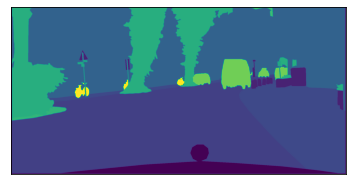

mask_org shape: (1024, 2048, 1)
label ids: [ 1.  3.  4.  7.  8. 11. 17. 20. 21. 22. 23. 26. 33.]


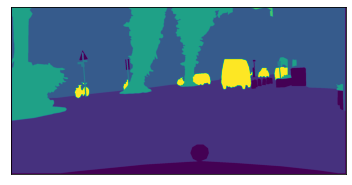


 mask_chg shape: (1024, 2048, 1)
class ids: [0. 1. 2. 3. 4. 5. 7.]


In [11]:
for i in range(1):
    img = load_img(train_mask_paths[i], color_mode="grayscale")
    mask=img_to_array(img)
    mask_show(mask)
    print("mask_org shape:", mask.shape)
    print('label ids:',np.unique(mask))
    
    cat = encode_labels(mask)
    mask_show(cat)
    print("\n mask_chg shape:", cat.shape)
    print('class ids:',np.unique(cat))

### Augmentations

In [12]:
# define simple augmentations
def get_flip_augmentation():
    train_transform = [
            #camera issues
            A.HorizontalFlip(p=0.8),
            A.Perspective(p=0.8),
            A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, shift_limit=0.1, p=0.2, border_mode=0),
    A.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, always_apply=True, border_mode=0),
    ]
    return A.Compose(train_transform)


In [13]:
# define simple augmentations
def get_noise_augmentation():
    train_transform = [
            #camera issues
            A.RandomBrightnessContrast(p=0.3),
            A.GaussNoise(p=0.3),
            A.Blur(blur_limit=3, p=0.2),
            A.HueSaturationValue(p=0.2),
    A.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, always_apply=True, border_mode=0),
    ]
    return A.Compose(train_transform)

In [14]:
# define heavy augmentations
def get_heavy_augmentation():
    train_transform = [
            #camera issues
            A.HorizontalFlip(p=0.8),
            A.Perspective(p=0.8),
            A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, shift_limit=0.1, p=0.2, border_mode=0),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussNoise(p=0.3),
            A.Blur(blur_limit=3, p=0.2),
            A.HueSaturationValue(p=0.2),
    A.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, always_apply=True, border_mode=0),
    ]
    return A.Compose(train_transform)


In [15]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(HEIGHT, WIDTH)
    ]
    return A.Compose(test_transform)


### preprocessing

In [16]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

### Buiding a data generator class

In [17]:
# classes for data loading and preprocessing
class Dataloader(keras.utils.all_utils.Sequence):
    """Load data from dataset and form batches
    """
    
    CLASSES = ['void', 'flat', 'construction', 'object', 'nature', 
               'sky', 'human', 'vehicle']
    
    
    def __init__(
            self, 
            img_paths, mask_paths,
            img_size,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            batch_size = 1,
            shuffle=False,
            ):
        
        self.ids = img_paths
        self.images_fps = img_paths
        self.masks_fps = mask_paths
        self.img_size = img_size
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.ids) // self.batch_size      
    
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        x=[]
        y=[]
        for j in range(start, stop):
            # read data and resize image
            image = cv2.imread(self.images_fps[j])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.img_size, interpolation = cv2.INTER_AREA)

            # change categories and resize mask
            mask = cv2.imread(self.masks_fps[j], 0)
            mask = encode_labels(mask)
            mask = cv2.resize(mask, self.img_size, interpolation = cv2.INTER_AREA)

            # extract certain classes from mask (e.g. cars)
            masks = [(mask == v) for v in self.class_values]
            mask = np.stack(masks, axis=-1).astype('float')
            # add background if mask is not binary
            if mask.shape[-1] != 1:
                background = 1 - mask.sum(axis=-1, keepdims=True)
                mask = np.concatenate((mask, background), axis=-1)

            # apply augmentations
            if self.augmentation:
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']

            # apply preprocessing
            if self.preprocessing:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
        
            x.append(image)
            y.append(mask)
        
        #  add one more batch dimension to the images/mask arrays.
        batch_x = np.array([np.stack(samples, axis=0) for samples in x])
        batch_y = np.array([np.stack(samples, axis=0) for samples in y])      
        
        return batch_x, batch_y

## Data generation

In [18]:
BATCH_SIZE = 2

# Dataset for train images
train_dataloader = Dataloader(
    train_img_paths, 
    train_mask_paths,
    img_size=IMG_SIZE,
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
    batch_size=BATCH_SIZE, shuffle=True
)

# Dataset for validation images
valid_dataloader = Dataloader(
    val_img_paths, 
    val_mask_paths,
    img_size=IMG_SIZE,
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
    batch_size=1, shuffle=False
)
# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, HEIGHT, WIDTH, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, HEIGHT, WIDTH, n_classes)

In [19]:
# Dataset for train images with augmentation

train_flipaug_dataloader = Dataloader(
    train_img_paths, 
    train_mask_paths,
    img_size = IMG_SIZE,
    classes=CLASSES, 
    augmentation=get_flip_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    batch_size=BATCH_SIZE, shuffle=True
)

# check shapes for errors
assert train_flipaug_dataloader[0][0].shape == (BATCH_SIZE, HEIGHT, WIDTH, 3)
assert train_flipaug_dataloader[0][1].shape == (BATCH_SIZE, HEIGHT, WIDTH, n_classes)

In [20]:
# Dataset for train images with augmentation

train_noiseaug_dataloader = Dataloader(
    train_img_paths, 
    train_mask_paths,
    img_size = IMG_SIZE,
    classes=CLASSES, 
    augmentation=get_noise_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    batch_size=BATCH_SIZE, shuffle=True
)

# check shapes for errors
assert train_noiseaug_dataloader[0][0].shape == (BATCH_SIZE, HEIGHT, WIDTH, 3)
assert train_noiseaug_dataloader[0][1].shape == (BATCH_SIZE, HEIGHT, WIDTH, n_classes)

In [21]:
# Dataset for train images with augmentation

train_heavyaug_dataloader = Dataloader(
    train_img_paths, 
    train_mask_paths,
    img_size = IMG_SIZE,
    classes=CLASSES, 
    augmentation=get_heavy_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    batch_size=BATCH_SIZE, shuffle=True
)

# check shapes for errors
assert train_heavyaug_dataloader[0][0].shape == (BATCH_SIZE, HEIGHT, WIDTH, 3)
assert train_heavyaug_dataloader[0][1].shape == (BATCH_SIZE, HEIGHT, WIDTH, n_classes)

## Models training

In [22]:
# define optomizer
LR= 0.0001
optim = tf.keras.optimizers.Adam(LR)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [23]:
def history_plot(history):# Plot training & validation iou_score values
    plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.plot(history.history['iou_score'])
    plt.plot(history.history['val_iou_score'])
    plt.title('Best val_iou_score: '+ str(max(history.history['val_iou_score'])))
    plt.ylabel('iou_score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['f1-score'])
    plt.plot(history.history['val_f1-score'])
    plt.title('Best val_f1-score: ' + str(max(history.history['val_f1-score'])))
    plt.ylabel('f1-score(dice coeff)')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

 ## Testing differrent loss functions

### 00. model training with CategoricalFocalLoss

In [24]:
keras.backend.clear_session()

# dice coeff loss
total_loss = sm.losses.categorical_focal_loss 
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('outputs/pspnet00.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]

model00 = sm.PSPNet(BACKBONE,encoder_weights='imagenet',encoder_freeze=True, classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model00.compile(optim, total_loss, metrics)

In [27]:
%%time

EPOCHS = 15

# train model
history00 = model00.fit(
    train_dataloader, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    shuffle=True
)

Epoch 1/15
158/158 [==============================] - 344s 2s/step - loss: 0.0136 - iou_score: 0.4239 - f1-score: 0.5082 - val_loss: 0.0106 - val_iou_score: 0.3470 - val_f1-score: 0.4133 - lr: 1.0000e-04
Epoch 2/15
158/158 [==============================] - 74s 468ms/step - loss: 0.0084 - iou_score: 0.5072 - f1-score: 0.5932 - val_loss: 0.0086 - val_iou_score: 0.4581 - val_f1-score: 0.5385 - lr: 1.0000e-04
Epoch 3/15
158/158 [==============================] - 76s 476ms/step - loss: 0.0071 - iou_score: 0.5328 - f1-score: 0.6159 - val_loss: 0.0077 - val_iou_score: 0.5126 - val_f1-score: 0.5869 - lr: 1.0000e-04
Epoch 4/15
158/158 [==============================] - 73s 463ms/step - loss: 0.0065 - iou_score: 0.5507 - f1-score: 0.6326 - val_loss: 0.0081 - val_iou_score: 0.5136 - val_f1-score: 0.5942 - lr: 1.0000e-04
Epoch 5/15
158/158 [==============================] - 73s 459ms/step - loss: 0.0060 - iou_score: 0.5638 - f1-score: 0.6446 - val_loss: 0.0077 - val_iou_score: 0.5210 - val_f1-sco

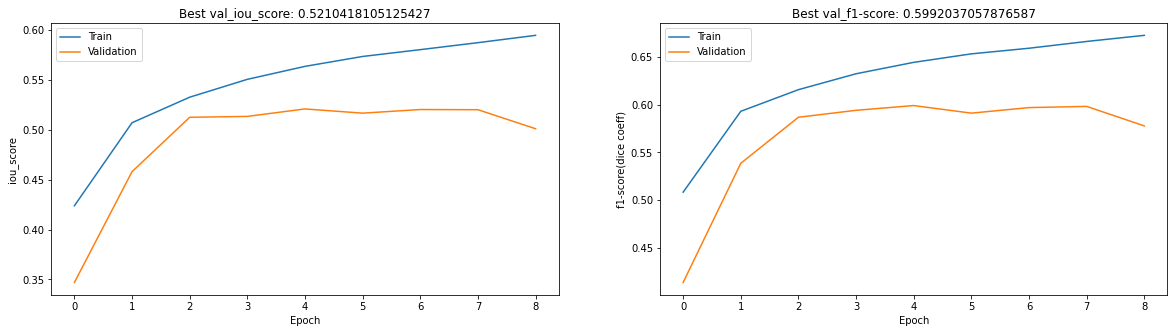

In [28]:
history_plot(history00)

### 01. model training with DiceLoss

In [24]:
keras.backend.clear_session()

# dice coeff loss
total_loss = sm.losses.dice_loss 
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('outputs/pspnet01.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]

model01 = sm.PSPNet(BACKBONE,encoder_weights='imagenet',encoder_freeze=True, classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model01.compile(optim, total_loss, metrics)

In [25]:
%%time

EPOCHS = 15

# train model
history01 = model01.fit(
    train_dataloader, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    shuffle=True
)

Epoch 1/15
158/158 [==============================] - 101s 585ms/step - loss: 0.5743 - iou_score: 0.4650 - f1-score: 0.5535 - val_loss: 0.5868 - val_iou_score: 0.4720 - val_f1-score: 0.5612 - lr: 1.0000e-04
Epoch 2/15
158/158 [==============================] - 94s 591ms/step - loss: 0.4853 - iou_score: 0.5502 - f1-score: 0.6464 - val_loss: 0.4980 - val_iou_score: 0.5458 - val_f1-score: 0.6334 - lr: 1.0000e-04
Epoch 3/15
158/158 [==============================] - 101s 637ms/step - loss: 0.4551 - iou_score: 0.5792 - f1-score: 0.6761 - val_loss: 0.4836 - val_iou_score: 0.5522 - val_f1-score: 0.6387 - lr: 1.0000e-04
Epoch 4/15
158/158 [==============================] - 87s 547ms/step - loss: 0.4385 - iou_score: 0.5935 - f1-score: 0.6905 - val_loss: 0.4785 - val_iou_score: 0.5585 - val_f1-score: 0.6422 - lr: 1.0000e-04
Epoch 5/15
158/158 [==============================] - 86s 546ms/step - loss: 0.4254 - iou_score: 0.6057 - f1-score: 0.7021 - val_loss: 0.4664 - val_iou_score: 0.5690 - val_f1

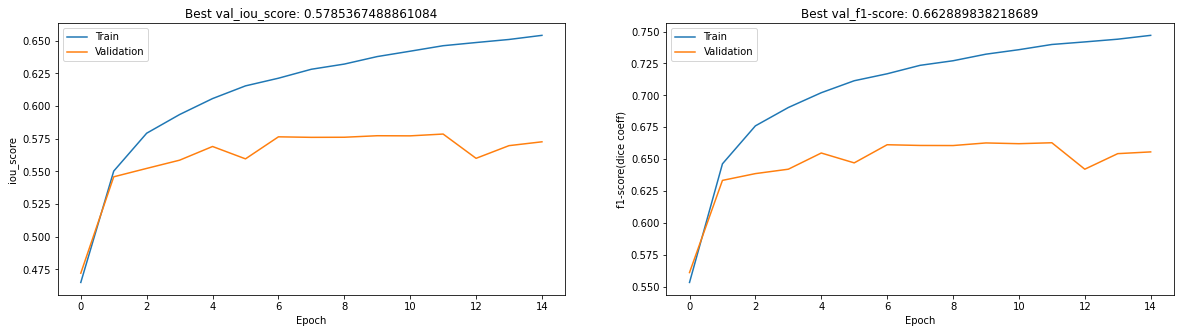

In [27]:
history_plot(history01)

###  02. model training with CategoricalFocalLoss + DiceLoss

In [28]:
keras.backend.clear_session()

# dice coeff loss
total_loss = sm.losses.categorical_focal_dice_loss 
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('outputs/pspnet02.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]

model02 = sm.PSPNet(BACKBONE,encoder_weights='imagenet',encoder_freeze=True, classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model02.compile(optim, total_loss, metrics)

In [29]:
%%time

EPOCHS = 15

# train model
history02 = model02.fit(
    train_dataloader, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    shuffle=True
)

Epoch 1/15
158/158 [==============================] - 65s 384ms/step - loss: 0.5479 - iou_score: 0.5111 - f1-score: 0.6019 - val_loss: 0.5215 - val_iou_score: 0.5425 - val_f1-score: 0.6323 - lr: 1.0000e-04
Epoch 2/15
158/158 [==============================] - 60s 381ms/step - loss: 0.4702 - iou_score: 0.5825 - f1-score: 0.6779 - val_loss: 0.4888 - val_iou_score: 0.5686 - val_f1-score: 0.6546 - lr: 1.0000e-04
Epoch 3/15
158/158 [==============================] - 72s 453ms/step - loss: 0.4481 - iou_score: 0.6027 - f1-score: 0.6975 - val_loss: 0.4796 - val_iou_score: 0.5721 - val_f1-score: 0.6594 - lr: 1.0000e-04
Epoch 4/15
158/158 [==============================] - 75s 474ms/step - loss: 0.4329 - iou_score: 0.6172 - f1-score: 0.7116 - val_loss: 0.4777 - val_iou_score: 0.5774 - val_f1-score: 0.6626 - lr: 1.0000e-04
Epoch 5/15
158/158 [==============================] - 74s 467ms/step - loss: 0.4227 - iou_score: 0.6269 - f1-score: 0.7206 - val_loss: 0.4871 - val_iou_score: 0.5687 - val_f1-s

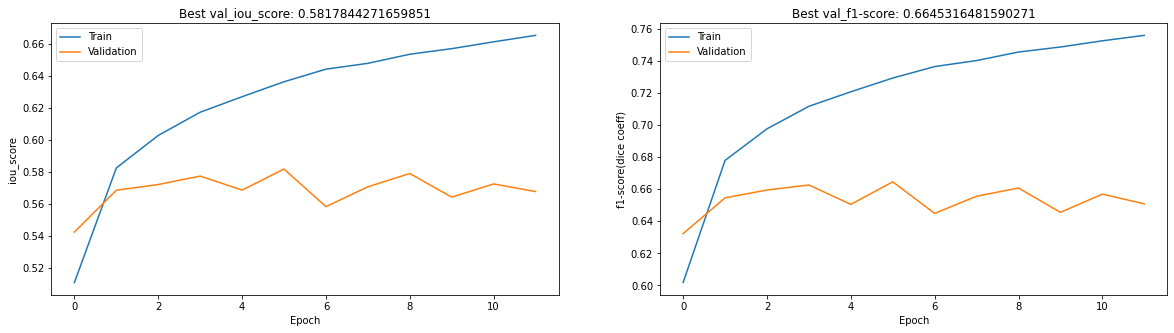

In [30]:
history_plot(history02)

###  03. model training with CategoricalFocalLoss + JaccordLoss

In [31]:
keras.backend.clear_session()

# jaccard coeff loss
total_loss = sm.losses.categorical_focal_jaccard_loss 
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('outputs/pspnet03.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]

model03 = sm.PSPNet(BACKBONE,encoder_weights='imagenet',encoder_freeze=True, classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model03.compile(optim, total_loss, metrics)

In [32]:
%%time

EPOCHS = 15

# train model
history03 = model03.fit(
    train_dataloader, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    shuffle=True
)

Epoch 1/15
158/158 [==============================] - 64s 380ms/step - loss: 0.6350 - iou_score: 0.5154 - f1-score: 0.6039 - val_loss: 0.6466 - val_iou_score: 0.5055 - val_f1-score: 0.5934 - lr: 1.0000e-04
Epoch 2/15
158/158 [==============================] - 59s 372ms/step - loss: 0.5639 - iou_score: 0.5846 - f1-score: 0.6769 - val_loss: 0.5717 - val_iou_score: 0.5738 - val_f1-score: 0.6569 - lr: 1.0000e-04
Epoch 3/15
158/158 [==============================] - 64s 402ms/step - loss: 0.5405 - iou_score: 0.6064 - f1-score: 0.6984 - val_loss: 0.5798 - val_iou_score: 0.5629 - val_f1-score: 0.6469 - lr: 1.0000e-04
Epoch 4/15
158/158 [==============================] - 72s 454ms/step - loss: 0.5266 - iou_score: 0.6189 - f1-score: 0.7106 - val_loss: 0.5585 - val_iou_score: 0.5864 - val_f1-score: 0.6688 - lr: 1.0000e-04
Epoch 5/15
158/158 [==============================] - 72s 453ms/step - loss: 0.5147 - iou_score: 0.6298 - f1-score: 0.7203 - val_loss: 0.5655 - val_iou_score: 0.5772 - val_f1-s

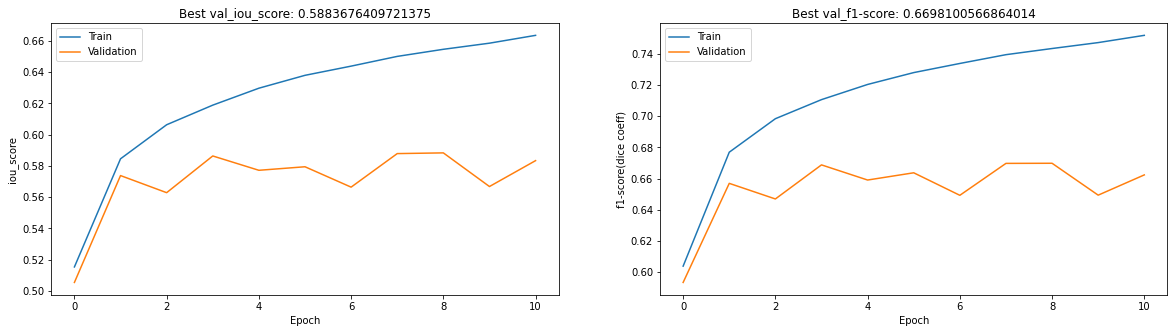

In [33]:
history_plot(history03)

##  Test different data augmentation techniques

### 1.1 Flip & Rotation & perpectives

In [50]:
keras.backend.clear_session()

# dice coeff loss
total_loss = sm.losses.categorical_focal_dice_loss 
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('outputs/pspnet11_flipaug.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]

model11 = sm.PSPNet(BACKBONE,encoder_weights='imagenet',encoder_freeze=True,  classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model11.compile(optim, total_loss, metrics)

In [51]:
%%time

EPOCHS = 15

# train model
history11_flipaug = model11.fit(
    train_flipaug_dataloader, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader,
    shuffle=True
)

Epoch 1/15
158/158 [==============================] - 78s 464ms/step - loss: 0.5912 - iou_score: 0.4671 - f1-score: 0.5580 - val_loss: 0.6078 - val_iou_score: 0.4493 - val_f1-score: 0.5356 - lr: 1.0000e-04
Epoch 2/15
158/158 [==============================] - 85s 540ms/step - loss: 0.5187 - iou_score: 0.5333 - f1-score: 0.6298 - val_loss: 0.5048 - val_iou_score: 0.5494 - val_f1-score: 0.6390 - lr: 1.0000e-04
Epoch 3/15
158/158 [==============================] - 90s 566ms/step - loss: 0.5009 - iou_score: 0.5509 - f1-score: 0.6470 - val_loss: 0.5006 - val_iou_score: 0.5537 - val_f1-score: 0.6399 - lr: 1.0000e-04
Epoch 4/15
158/158 [==============================] - 89s 561ms/step - loss: 0.4879 - iou_score: 0.5638 - f1-score: 0.6592 - val_loss: 0.4921 - val_iou_score: 0.5614 - val_f1-score: 0.6482 - lr: 1.0000e-04
Epoch 5/15
158/158 [==============================] - 89s 564ms/step - loss: 0.4829 - iou_score: 0.5680 - f1-score: 0.6632 - val_loss: 0.4871 - val_iou_score: 0.5705 - val_f1-s

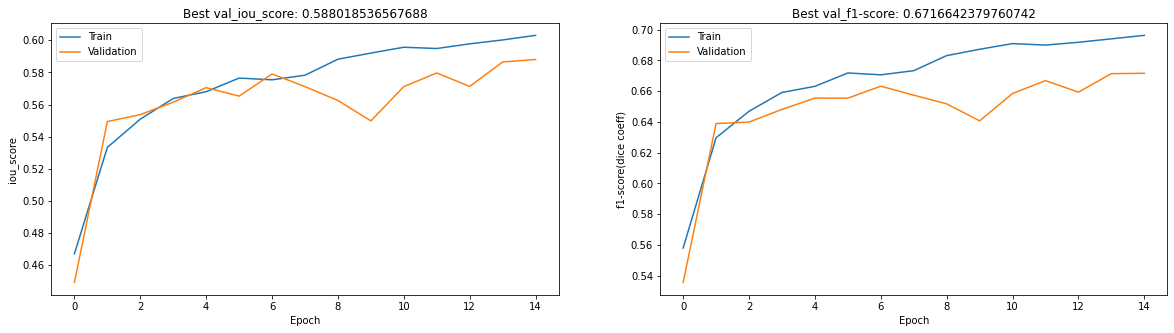

In [52]:
history_plot(history11_flipaug)

### 1.2 Using Gaussien noise & Brightness & Blur & Saturation

In [53]:
keras.backend.clear_session()
#release all the gpu memory
device.reset()

# dice coeff loss
total_loss = sm.losses.categorical_focal_dice_loss 
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('outputs/pspnet11_noiseaug.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]

model11 = sm.PSPNet(BACKBONE,encoder_weights='imagenet',encoder_freeze=True, classes=n_classes, activation=activation)


# compile keras model with defined optimozer, loss and metrics
model11.compile(optim, total_loss, metrics)

In [54]:
%%time

EPOCHS = 15

# train model
history11_noiseaug = model11.fit(
    train_noiseaug_dataloader, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader,
    shuffle=True
)

Epoch 1/15
158/158 [==============================] - 85s 501ms/step - loss: 0.5587 - iou_score: 0.4998 - f1-score: 0.5932 - val_loss: 0.5457 - val_iou_score: 0.5073 - val_f1-score: 0.5999 - lr: 1.0000e-04
Epoch 2/15
158/158 [==============================] - 79s 496ms/step - loss: 0.4845 - iou_score: 0.5679 - f1-score: 0.6646 - val_loss: 0.5175 - val_iou_score: 0.5355 - val_f1-score: 0.6206 - lr: 1.0000e-04
Epoch 3/15
158/158 [==============================] - 78s 491ms/step - loss: 0.4602 - iou_score: 0.5908 - f1-score: 0.6869 - val_loss: 0.4845 - val_iou_score: 0.5716 - val_f1-score: 0.6557 - lr: 1.0000e-04
Epoch 4/15
158/158 [==============================] - 78s 493ms/step - loss: 0.4492 - iou_score: 0.6007 - f1-score: 0.6963 - val_loss: 0.4791 - val_iou_score: 0.5758 - val_f1-score: 0.6604 - lr: 1.0000e-04
Epoch 5/15
158/158 [==============================] - 78s 495ms/step - loss: 0.4409 - iou_score: 0.6084 - f1-score: 0.7039 - val_loss: 0.4802 - val_iou_score: 0.5744 - val_f1-s

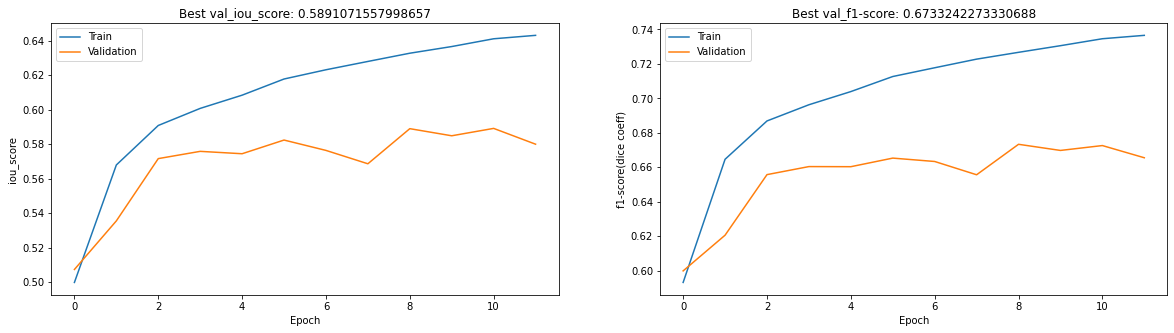

In [55]:
history_plot(history11_noiseaug)

### 1.3 Using all data augmentation techniques

In [41]:
keras.backend.clear_session()

# jaccard coeff loss
total_loss = sm.losses.categorical_focal_dice_loss 
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('outputs/pspnet11_heavyaug.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]

model11 = sm.PSPNet(BACKBONE,encoder_weights='imagenet',encoder_freeze=True, classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model11.compile(optim, total_loss, metrics)

In [32]:
%%time

EPOCHS = 15

# train model
history11_heavyaug= model11.fit(
    train_heavyaug_dataloader, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    shuffle=True
)

Epoch 1/15
158/158 [==============================] - 78s 466ms/step - loss: 0.6069 - iou_score: 0.4526 - f1-score: 0.5420 - val_loss: 0.5559 - val_iou_score: 0.5028 - val_f1-score: 0.5920 - lr: 1.0000e-04
Epoch 2/15
158/158 [==============================] - 90s 570ms/step - loss: 0.5281 - iou_score: 0.5249 - f1-score: 0.6220 - val_loss: 0.5243 - val_iou_score: 0.5327 - val_f1-score: 0.6191 - lr: 1.0000e-04
Epoch 3/15
158/158 [==============================] - 90s 569ms/step - loss: 0.5133 - iou_score: 0.5387 - f1-score: 0.6360 - val_loss: 0.5257 - val_iou_score: 0.5296 - val_f1-score: 0.6159 - lr: 1.0000e-04
Epoch 4/15
158/158 [==============================] - 92s 579ms/step - loss: 0.4973 - iou_score: 0.5540 - f1-score: 0.6507 - val_loss: 0.5075 - val_iou_score: 0.5471 - val_f1-score: 0.6349 - lr: 1.0000e-04
Epoch 5/15
158/158 [==============================] - 90s 567ms/step - loss: 0.4891 - iou_score: 0.5615 - f1-score: 0.6573 - val_loss: 0.5171 - val_iou_score: 0.5366 - val_f1-s

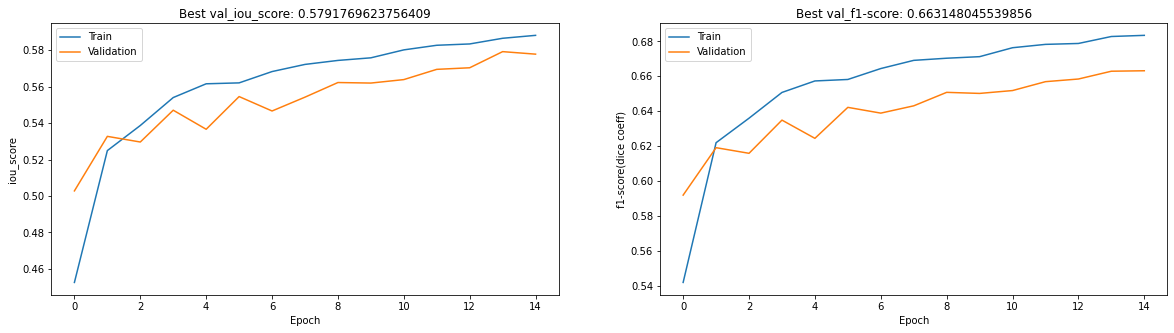

In [35]:
history_plot(history11_heavyaug)

## Visualization of a prediction

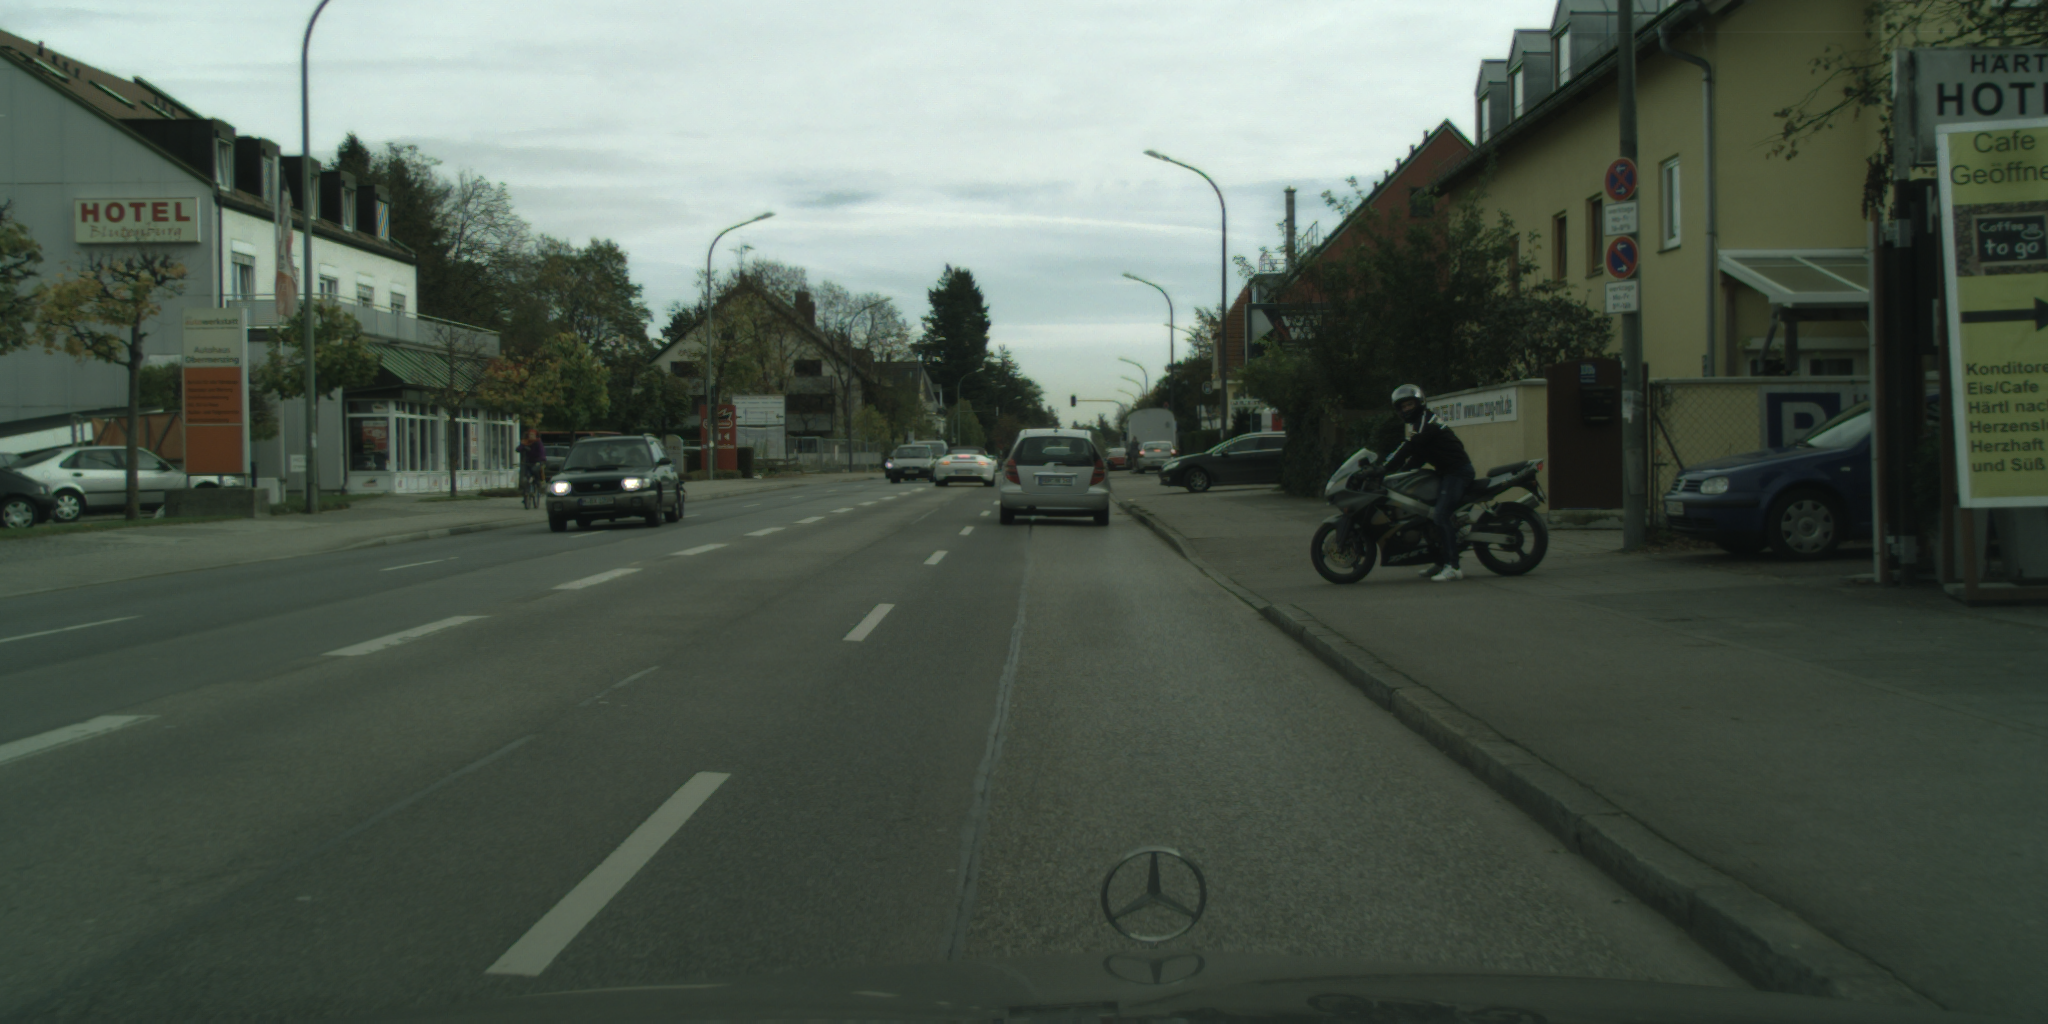

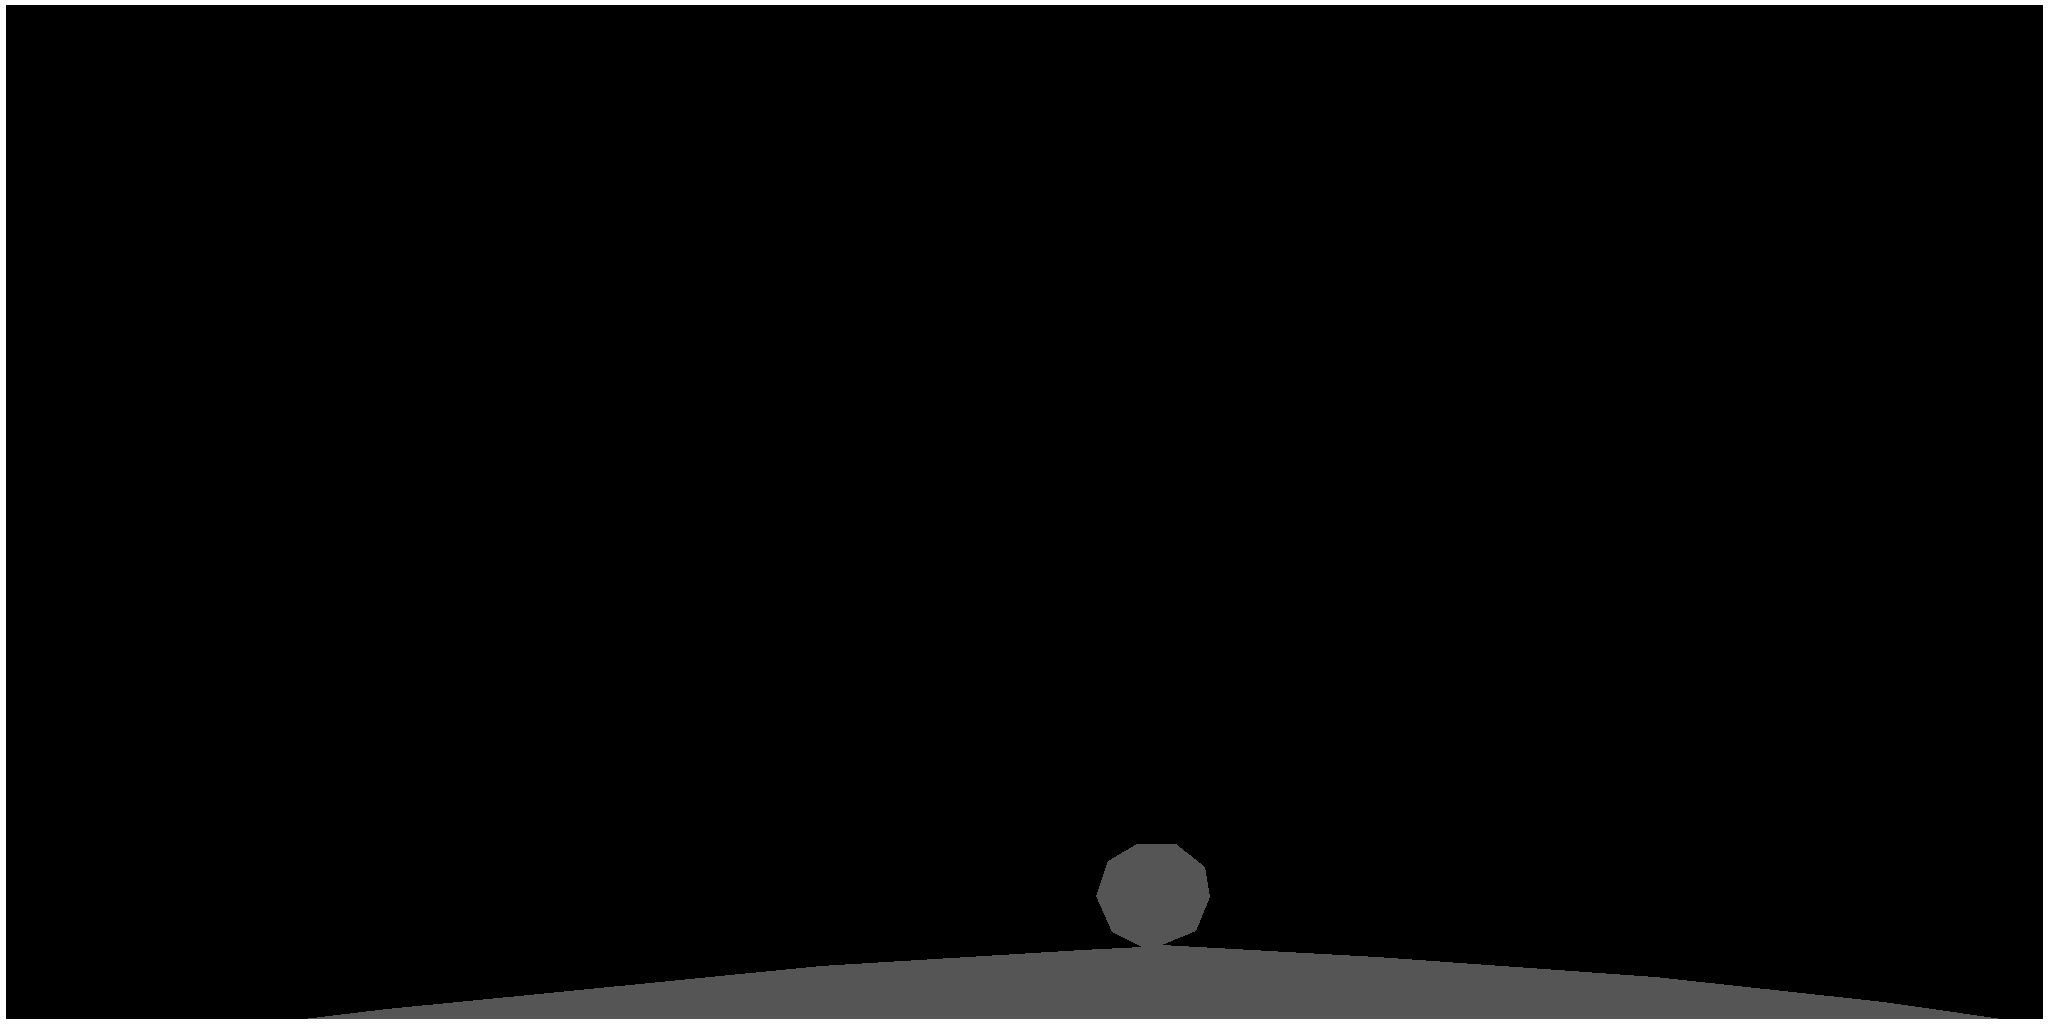

In [55]:
# Display results for validation image #1
i = 0

# Display input image
image = Image(filename=test_img_paths[i])
display(image)

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(test_mask_paths[i]))
display(img)

In [28]:
test_dataloader = Dataloader(
    test_img_paths, 
    test_mask_paths,
    img_size=IMG_SIZE,
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    batch_size=1, 
    shuffle=False
)

In [85]:
image = cv2.imread(test_img_paths[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [29]:
def display_mask(test_pred):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_pred, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

In [64]:
def make_real_mask(pred, image):
    pred=cv2.resize(pred.squeeze(), (2048,1024), interpolation = cv2.INTER_AREA)
    mask = np.argmax(pred, axis=-1)
    
    result_image = color.label2rgb(mask, image)
    result_image =(result_image*255).astype(np.uint8)
    return result_image

In [120]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        image=cv2.resize(image.squeeze(), (2048,1024), interpolation = cv2.INTER_AREA)
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

###  using CategoricalFocalLoss

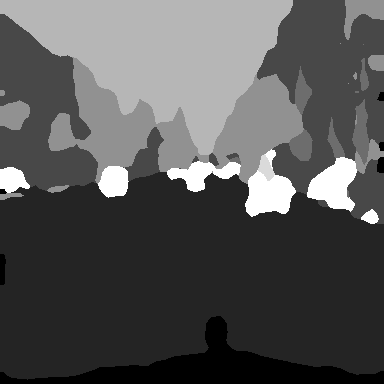

In [53]:
model00.load_weights('outputs/pspnet00.h5')
test_pred00 = model00.predict(test_dataloader)
# Display mask predicted by our model
display_mask(test_pred00[i]) 

###  using DiceLoss

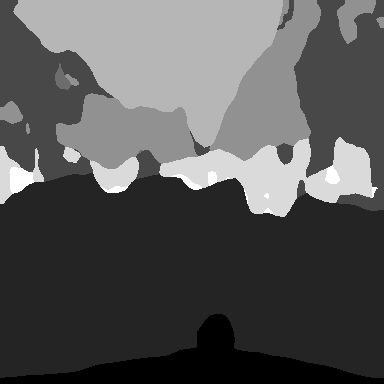

In [66]:
model01.load_weights('outputs/pspnet01.h5')
test_pred01 = model01.predict(test_dataloader)
# Display mask predicted by our model
display_mask(test_pred01[i]) 

### Using compound loss

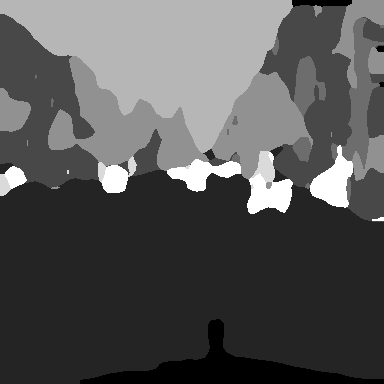

In [67]:
model02.load_weights('outputs/pspnet02.h5')
test_pred02 = model02.predict(test_dataloader)
# Display mask predicted by our model
display_mask(test_pred02[i]) 

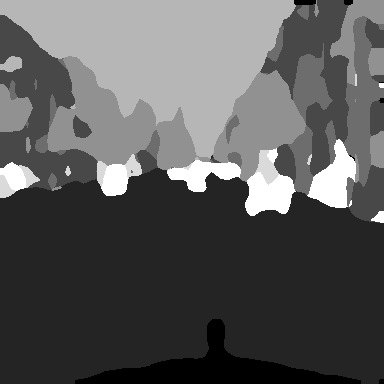

In [68]:
model03.load_weights('outputs/pspnet03.h5')
test_pred03 = model03.predict(test_dataloader)
# Display mask predicted by our model
display_mask(test_pred03[i]) 

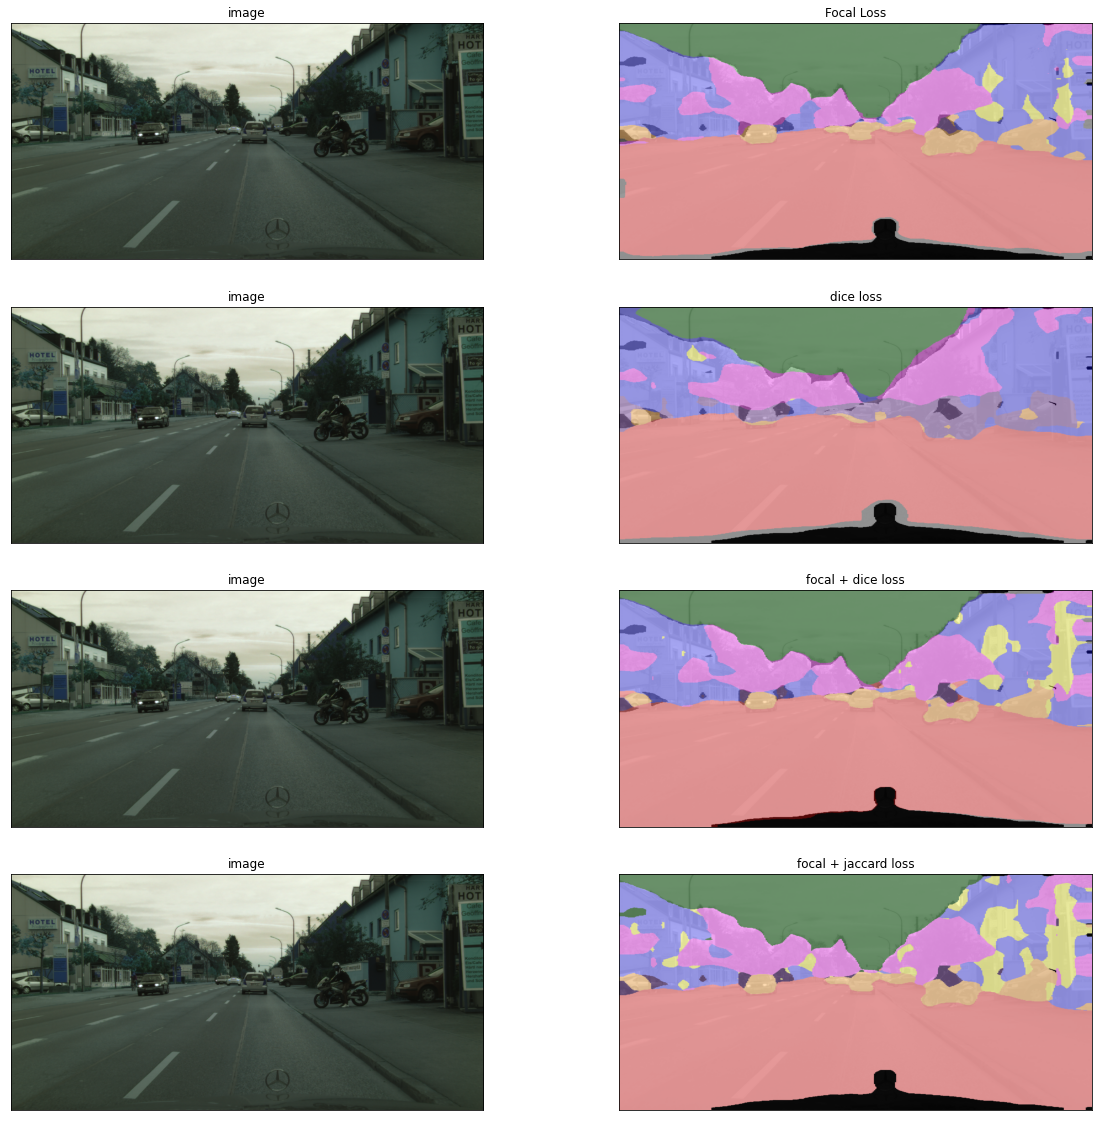

In [111]:
img= cv2.imread(test_img_paths[0])

display_list=[img,
              make_real_mask(test_pred00, image),
            img,
             make_real_mask(test_pred01, image),
              img,
             make_real_mask(test_pred02, image),
            img,
             make_real_mask(test_pred03, image),]
titles = ["image","Focal Loss","image","dice loss","image","focal + dice loss","image", "focal + jaccard loss"]

plt.figure(figsize=(20, 20))
for i, image in enumerate(display_list):
    image = display_list[i]
    plt.subplot(4, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[i])
    plt.imshow(image)
plt.show()

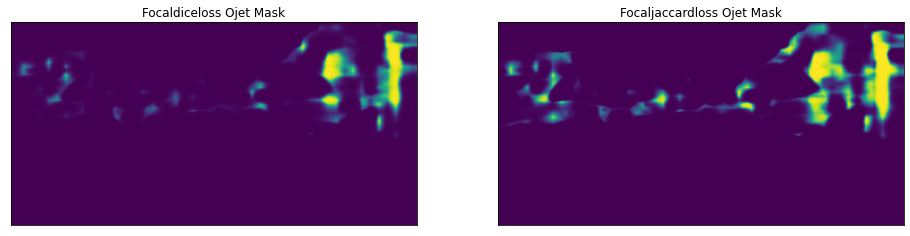

In [122]:
visualize(
    FocalDiceLoss_Ojet_mask=test_pred02[..., 3].squeeze(),
    FocalJaccardLoss_Ojet_mask=test_pred03[..., 3].squeeze()
)


### Data augmentation

In [103]:
model11.load_weights('outputs/pspnet11_flipaug.h5')
test_pred11_flipaug = model11.predict(test_dataloader)

model11.load_weights('outputs/pspnet11_noiseaug.h5')
test_pred11_noiseaug = model11.predict(test_dataloader)

model11.load_weights('outputs/pspnet11_heavyaug.h5')
test_pred11_aug = model11.predict(test_dataloader)

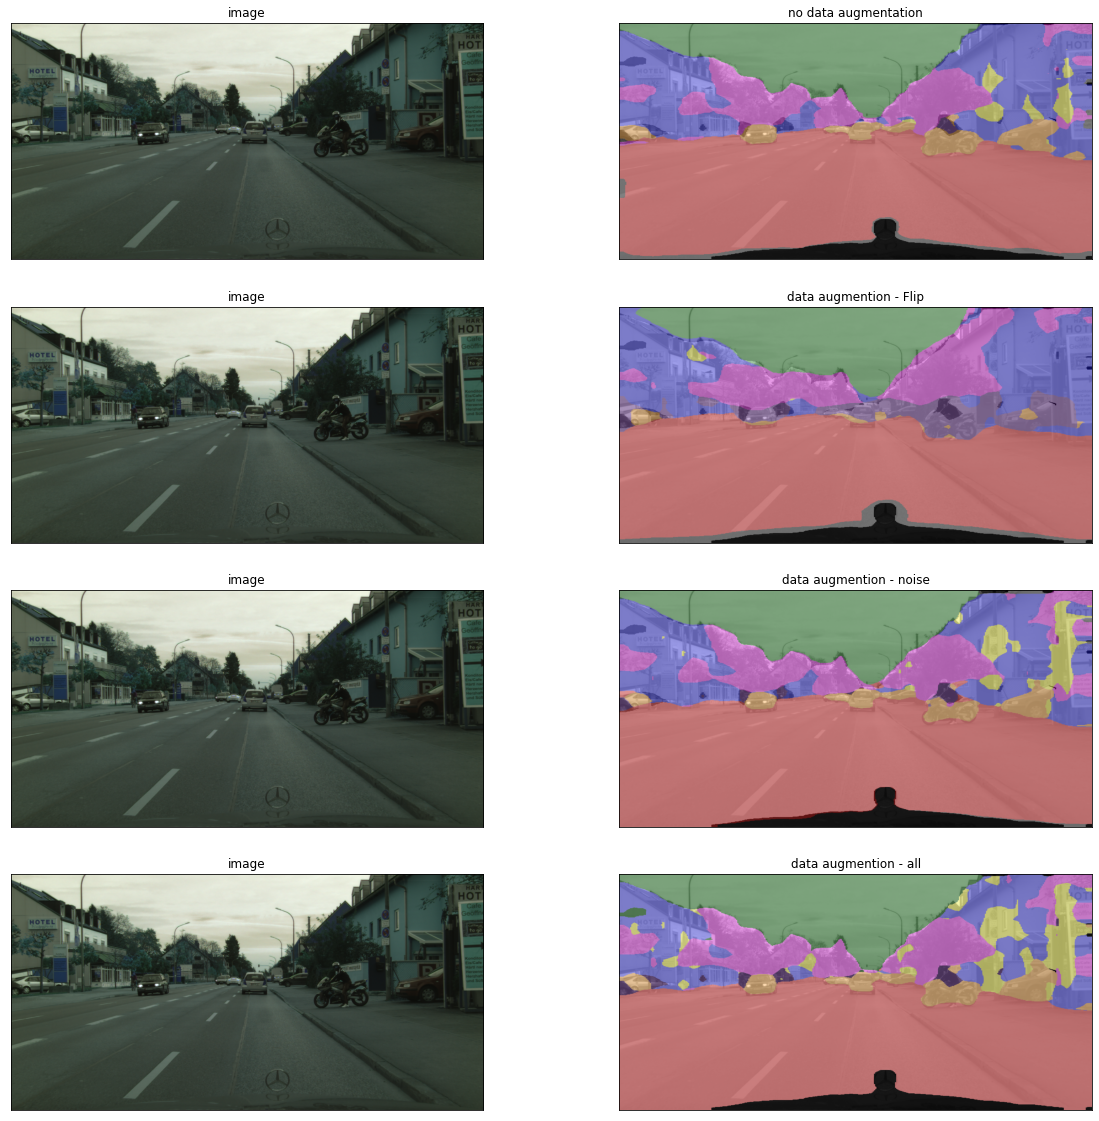

In [108]:
img= cv2.imread(test_img_paths[0])

aug_list=[img,
             make_real_mask(test_pred02, image),
               img,
             make_real_mask(test_pred11_flipaug, image),
              img,
             make_real_mask(test_pred11_noiseaug, image),
            img,
             make_real_mask(test_pred11_aug, image),]
          
aug_titles = ["image","no data augmentation",
              "image","data augmention - Flip",
          "image","data augmention - noise",
          "image", "data augmention - all"]

plt.figure(figsize=(20, 20))
for i, image in enumerate(aug_list):
    image = display_list[i]
    plt.subplot(8, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(aug_titles[i])
    plt.imshow(image)
plt.show()